# `labjack-controller` Demonstration Notebook
---
<h4><span style="color:gray">Montgomery, University of Southern Maine</span></h4>

### Notebook II: Operation in Parallel
Using the information from last time, we can start doing fun things with LJM devices, like using parallel processing to back up our data in realtime.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from labjackcontroller.labtools import LabjackReader

from multiprocessing.managers import BaseManager
from multiprocessing import Process

import time

In [2]:
device_type = "T7"
connection_type = "USB"
duration = 180  # seconds
freq = 100  # sampling frequency
channels = ["AIN0", "AIN1", "AIN2", "AIN3"]
voltages = [10.0, 10.0, 10.0, 10.0]

In [3]:
def backup(labjack: LabjackReader, filename: str, num_seconds: int) -> None:
    """
    Simple function to backup all data real-time into a pickle.

    Parameters
    ----------
    labjack: LabjackReader
        A LabjackReader that is collecting data at the
        time of this function's call.
    filename: str
        The name of the file to write to.
        If it does not exist yet, it will be created.
    num_seconds: int
        The number of seconds to try real-time backup.
        After this time, write any remaining data in
        the labjack's buffer.

    Returns
    -------
    None

    """
    start_time = time.time()
    # Write data until time is up.
    while time.time() - start_time <= num_seconds:
        if not (time.time() - start_time) % 60:
            print("Backup at", time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
            labjack.to_dataframe().to_pickle(filename)

BaseManagers can be used to share complex objects, attributes and all, across multiple processes. This is fantastic for our application, because we want all processes to be able to read the data we are in the process of collecting.

In [4]:
BaseManager.register('LabjackReader', LabjackReader)
manager = BaseManager()
manager.start()

# Instantiate a shared LabjackReader
my_lj = manager.LabjackReader(device_type, connection_type=connection_type)

In [ ]:
# Declare a data-gathering process
data_proc = Process(target=my_lj.collect_data,
                    args=(channels, voltages, duration, freq),
                    kwargs={'resolution': 1, 'scans_per_read': 1})

# Declare a data backup process
backup_proc = Process(target=backup, args=(my_lj, "backup.pkl",
                                           duration))

In [11]:
# Start all threads, and join when finished.
data_proc.start()
backup_proc.start()

data_proc.join()
backup_proc.join()

In [14]:
datarun = my_lj.to_dataframe()
datarun.rename(index=str, columns={"AIN0": "L-R", "AIN1": "T-B", "AIN2": "SUM", "AIN3": "TEMP"}, inplace=True)

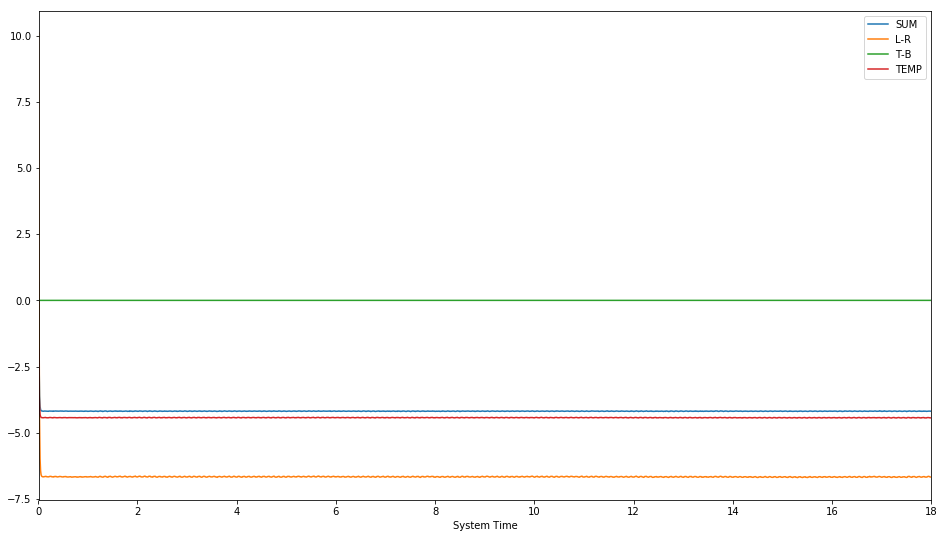

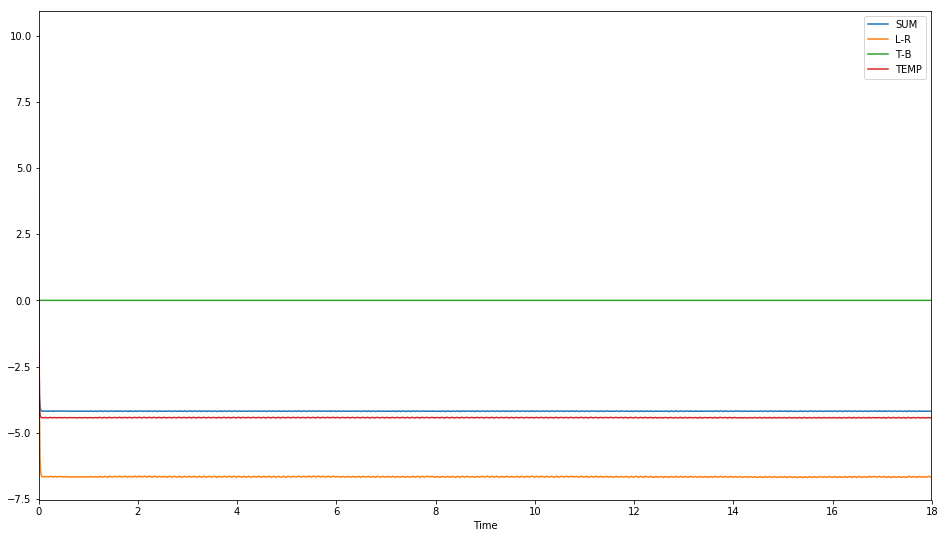

In [15]:
datarun[['SUM', 'L-R', 'T-B', 'TEMP', 'System Time']].plot(figsize=(16, 9), x='System Time')
plt.show()

datarun[['SUM', 'L-R', 'T-B', 'TEMP', 'Time']].plot(figsize=(16, 9), x='Time')
plt.show()

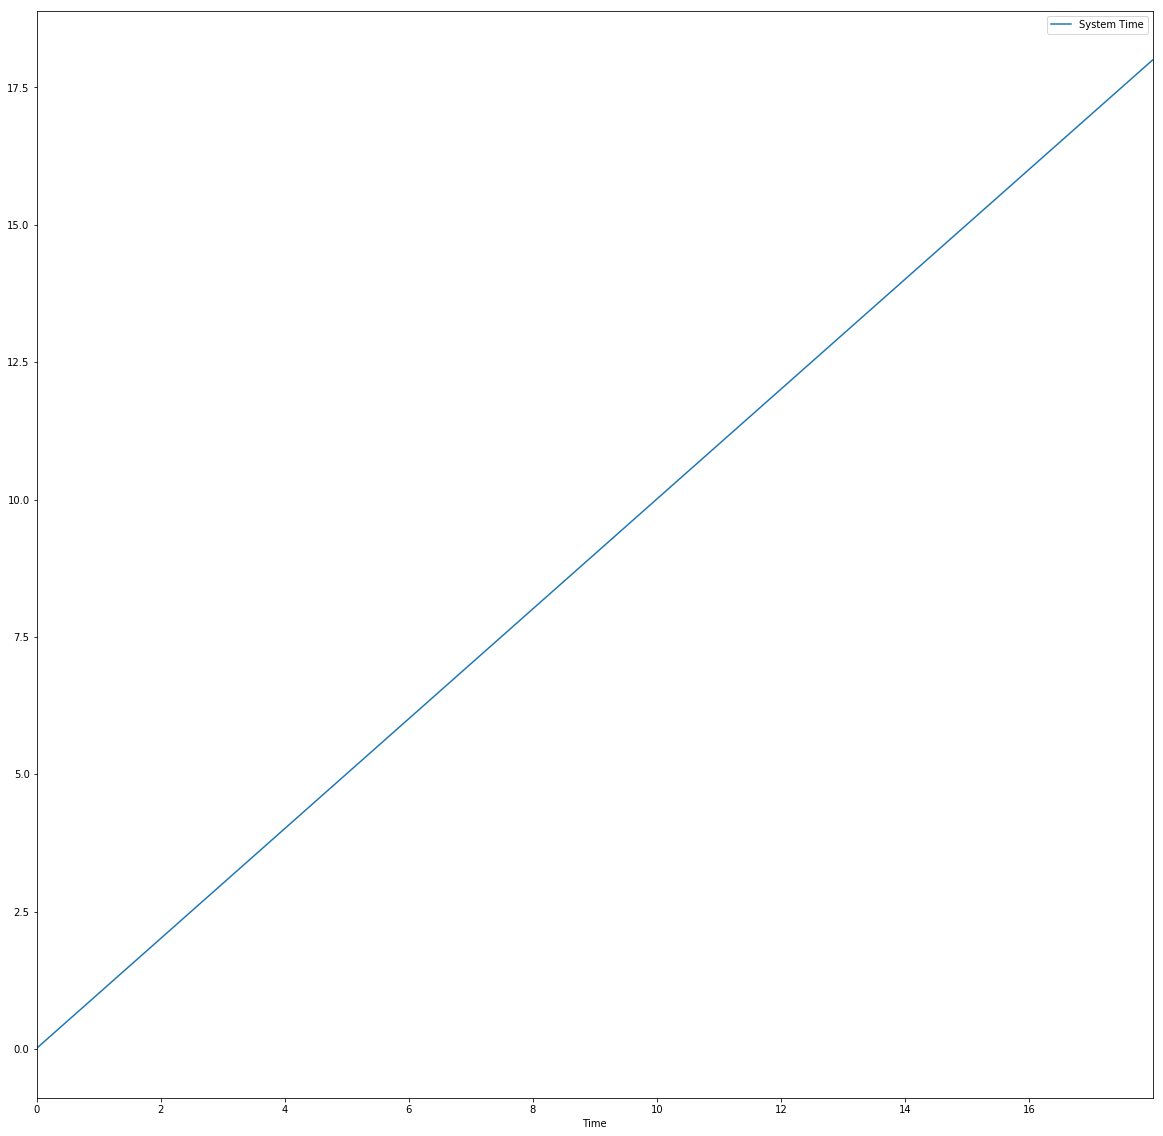

In [16]:
datarun[['Time', 'System Time']].plot(figsize=(20, 20), x='Time', y='System Time')